# Prep

In [528]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [529]:
#Configure DataFrame settings
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [530]:
#Import data
YEAR = 2020

df = pd.read_csv(
    'https://github.com/guga31bb/nflfastR-data/blob/master/data/play_by_play_' \
    + str(YEAR) + '.csv.gz?raw=True',compression='gzip', low_memory=False
    )

In [531]:
#Clean up air_yards fields as recommended in tutorial
df["air_yards"] = np.where(df["air_yards"]<-10, df["air_yards"].median(), df["air_yards"])

In [532]:
#df.head()

In [533]:
#Store list of columns for future reference
cols = sorted(list(df.columns))

#### Initialize DataFrame of QB ranks

In [534]:
qb_rank = df[["name","pass_attempt"]].groupby("name").sum().sort_values("pass_attempt",ascending=False).head(40).sort_values("name")
qb_rank.reset_index(level=0, inplace=True)
qb_rank = qb_rank.drop("pass_attempt",axis=1)
qb_rank["epa_points"] = 0
qb_rank["cpoe_points"] = 0
qb_rank["total"] = 0
qb_rank

,name,epa_points,cpoe_points,total
0,A.Dalton,0,0,0
1,A.Rodgers,0,0,0
2,A.Smith,0,0,0
3,B.Mayfield,0,0,0
4,B.Roethlisberger,0,0,0
...,...,...,...,...
35,R.Wilson,0,0,0
36,S.Darnold,0,0,0
37,T.Brady,0,0,0
38,T.Bridgewater,0,0,0


In [535]:
#Grab a list of the top 40 QBs by pass attempts
top_qbs = qb_rank["name"].tolist()

# Step 1: Ranking by EPA & CPOE

EPA - Expected Points Added: the average Expected Points Added per play in which an offensive player is directly involved. EPA/P is a measure of an individual player’s impact on the scores of his games, on a per play basis.

CPOE - Completion Percentage Over Expectation: the quarterback's actual completion percentage minus the expected completion percentage.

In [536]:
#Create a dataframe of their average EPA and CPOE per play
qb_stat1 = df[df["name"].isin(top_qbs)][["name","epa","cpoe"]].groupby("name").mean()
qb_stat1.reset_index(level=0, inplace=True)
qb_stat1.head()

,name,epa,cpoe
0,A.Dalton,0.009911,0.470069
1,A.Rodgers,0.307541,6.710711
2,A.Smith,-0.105925,-1.531392
3,B.Mayfield,0.153101,2.781959
4,B.Roethlisberger,0.085006,-1.063385


Text(0, 0.5, 'Expected Points Added Per Play')

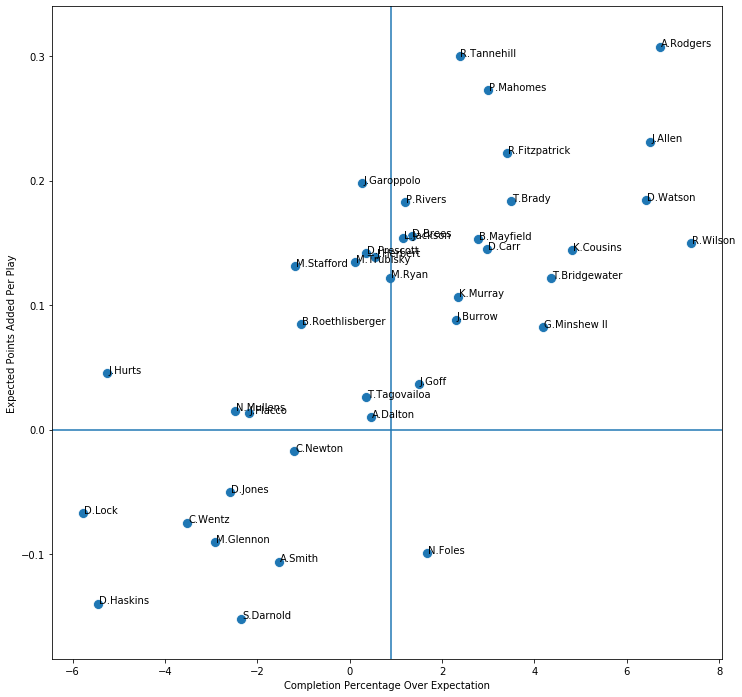

In [537]:
#Create scatterplot
plt.figure(figsize=(12,12))
g = sns.scatterplot(x="cpoe",y="epa",palette="Set1_r",data=qb_stat1,s=100)
g.axhline(0)
g.axvline(qb_stat1["cpoe"].mean())


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(qb_stat1.cpoe, qb_stat1.epa, qb_stat1.name, plt.gca())

plt.xlabel('Completion Percentage Over Expectation')
plt.ylabel('Expected Points Added Per Play')

#### Assign rankings
The best QB in a statistic is given 40 points, the second best 39 points, etc.

In [538]:
qb_rank["epa_points"] = qb_stat1["epa"].rank(method="max")
qb_rank["cpoe_points"] = qb_stat1["cpoe"].rank(method="max")
qb_rank["total"] = qb_rank["epa_points"]+qb_rank["cpoe_points"]
qb_rank.sort_values("total",ascending=False)

,name,epa_points,cpoe_points,total
1,A.Rodgers,40.0,39.0,79.0
15,J.Allen,37.0,38.0,75.0
13,D.Watson,34.0,37.0,71.0
31,P.Mahomes,38.0,31.0,69.0
33,R.Fitzpatrick,36.0,32.0,68.0
...,...,...,...,...
25,M.Glennon,5.0,5.0,10.0
6,C.Wentz,6.0,4.0,10.0
36,S.Darnold,1.0,8.0,9.0
11,D.Lock,7.0,1.0,8.0


# Step 2: Ranking by YPP and TD/Turnover Ratio
YPP - Yards Per Play: the average pass or rush yards gained each play by the quarterback.

TD/Turnover Ratio: the average touchdowns scored each play divided by the average fumbles or interceptions each play. (Note: I include all fumbles, not just fumbles lost, because once fumbled it is primarily based on luch which team recovers.)

In [539]:
#Create a DataFrame that holds the YPP and TD/Turnover Ratio

qb_stat2 = df[df["name"].isin(top_qbs)][["name","pass_touchdown","rush_touchdown","fumble","interception","yards_gained"]].groupby("name").mean()
qb_stat2["td_rate"] = qb_stat2["pass_touchdown"]+qb_stat2["rush_touchdown"]
qb_stat2["trnvr_rate"] = qb_stat2["fumble"]+qb_stat2["interception"]
qb_stat2["ratio"] = qb_stat2["td_rate"]/qb_stat2["trnvr_rate"]
qb_stat2.reset_index(level=0, inplace=True)
qb_stat2.sort_values("ratio",ascending=False)

,name,pass_touchdown,rush_touchdown,fumble,interception,yards_gained,td_rate,trnvr_rate,ratio
1,A.Rodgers,0.074957,0.005111,0.011925,0.008518,6.856899,0.080068,0.020443,3.916667
39,T.Tagovailoa,0.033898,0.010169,0.010169,0.006780,4.776271,0.044068,0.016949,2.600000
34,R.Tannehill,0.059041,0.009225,0.016605,0.012915,6.782288,0.068266,0.029520,2.312500
31,P.Mahomes,0.053446,0.004219,0.018284,0.008439,6.917018,0.057665,0.026723,2.157895
15,J.Allen,0.047288,0.011127,0.016690,0.012517,6.383866,0.058414,0.029207,2.000000
...,...,...,...,...,...,...,...,...,...
21,J.Hurts,0.029268,0.004878,0.043902,0.014634,6.136585,0.034146,0.058537,0.583333
11,D.Lock,0.029289,0.006276,0.031381,0.031381,5.520921,0.035565,0.062762,0.566667
10,D.Jones,0.016216,0.001802,0.023423,0.016216,5.142342,0.018018,0.039640,0.454545
2,A.Smith,0.015444,0.000000,0.015444,0.023166,5.023166,0.015444,0.038610,0.400000


Text(0, 0.5, 'TDs/Turnovers Per Play')

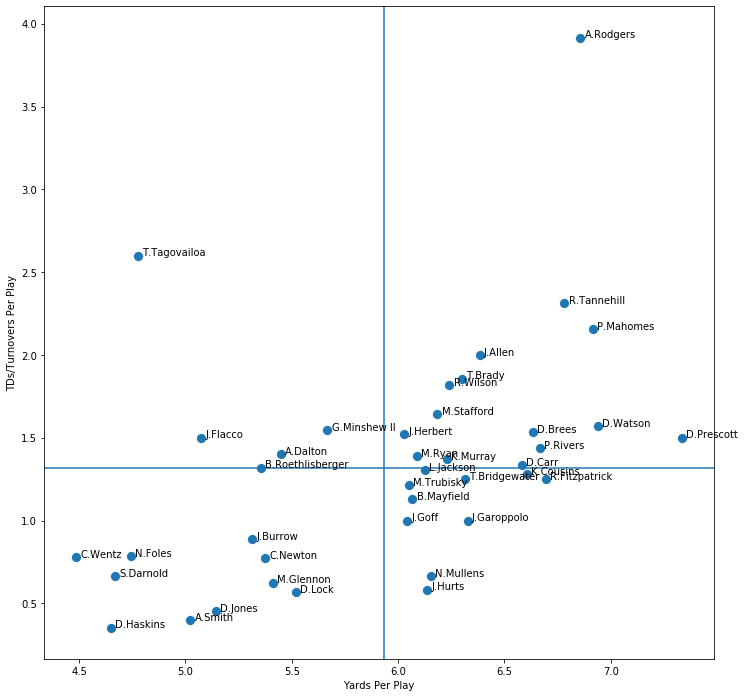

In [540]:
#Create scatterplot
plt.figure(figsize=(12,12))
g = sns.scatterplot(x="yards_gained",y="ratio",palette="Set1_r",data=qb_stat2,s=100)
g.axhline(qb_stat2["ratio"].mean())
g.axvline(qb_stat2["yards_gained"].mean())


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(qb_stat2.yards_gained, qb_stat2.ratio, qb_stat2.name, plt.gca()) 

plt.xlabel('Yards Per Play')
plt.ylabel('TDs/Turnovers Per Play')

#### Assign rankings

In [541]:
qb_rank["ypp_points"] = qb_stat2["yards_gained"].rank(method="max")
qb_rank["ratio_points"] = qb_stat2["ratio"].rank(method="max")
qb_rank = qb_rank.drop("total",axis=1)
qb_rank["total"] = qb_rank["epa_points"]+qb_rank["cpoe_points"]+qb_rank["ypp_points"]+qb_rank["ratio_points"]
qb_rank.sort_values("total",ascending=False)

,name,epa_points,cpoe_points,ypp_points,ratio_points,total
1,A.Rodgers,40.0,39.0,37.0,40.0,156.0
31,P.Mahomes,38.0,31.0,38.0,37.0,144.0
13,D.Watson,34.0,37.0,39.0,32.0,142.0
15,J.Allen,37.0,38.0,30.0,36.0,141.0
34,R.Tannehill,39.0,28.0,36.0,38.0,141.0
...,...,...,...,...,...,...
10,D.Jones,8.0,6.0,8.0,3.0,25.0
6,C.Wentz,6.0,4.0,1.0,10.0,21.0
2,A.Smith,3.0,10.0,6.0,2.0,21.0
36,S.Darnold,1.0,8.0,3.0,8.0,20.0


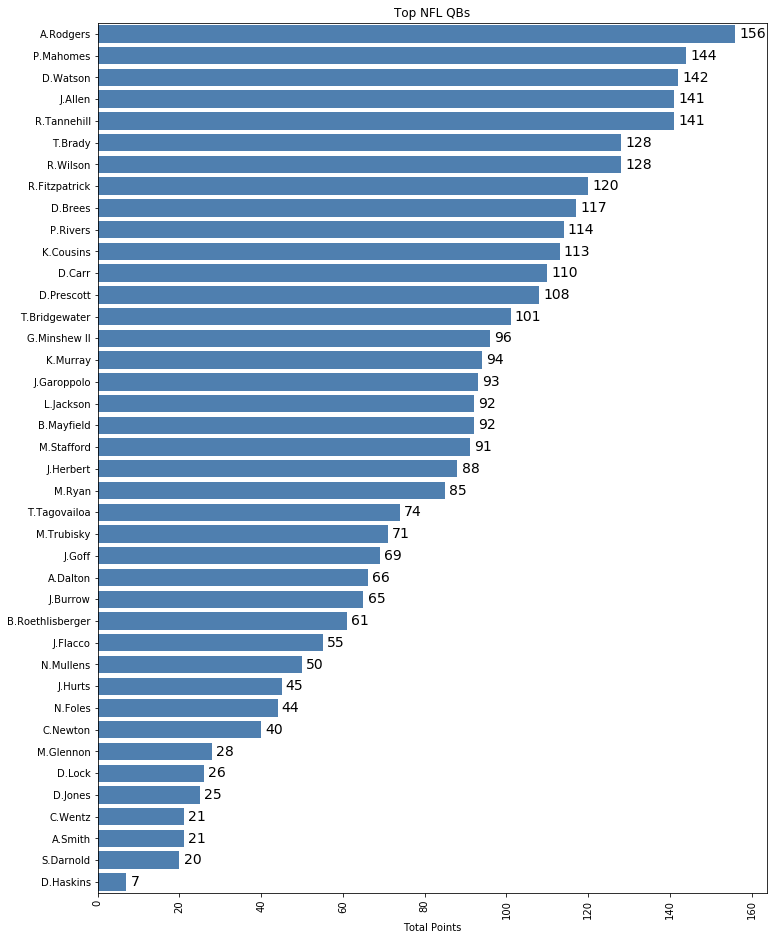

In [572]:
ranked_qb_list = list(qb_rank.sort_values("total",ascending=False)["name"])

fig, ax = plt.subplots(figsize=(12,16))
graph = sns.barplot(x="total",y="name",data=qb_rank,order=ranked_qb_list,color="#3F7FBF")

plt.xlabel("Total Points")
plt.ylabel("")
plt.title("Top NFL QBs")


for item in graph.get_xticklabels():
    item.set_rotation(90)
    
totals = qb_rank["total"].sort_values(ascending=False).astype(np.int64)
for i, v in enumerate(totals):
    ax.text(v + 1, i, str(v), color='black', fontweight='normal', fontsize=14, ha='left', va='center')